<a href="https://colab.research.google.com/github/brianmanderson/Image_Prediction/blob/main/Jose_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Licensed under the Apache License, Version 2.0 (the "License");

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#EPIDEEP: Generating EPID images

#Along with this code you will need input image files, these are stored as TFrecord files, a file type that is compatible with TensorFlow.
Also you will need the weights of the model.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


Workbook to make a prediction of in-vivo EPID images, using EPID images collected on the Varian Halcyon machine


## Import TensorFlow and other python libraries

In [3]:
import tensorflow as tf

import os
import sys
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.experimental.numpy as tnp
import pandas as pd
#print(sys.version_info)

Connect to Google Drive to access data, you will have to put the TFrecord data in folder on your google drive.  These commands connect to that parent folder

In [4]:
running_local = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    nb_path = '/content/notebooks'
    os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
    sys.path.insert(0, nb_path)  # or append(nb_path)
except:
    running_local = True
    print("Running locally")

Mounted at /content/drive



Line to install pymedphys which has a gamma function which is used in model assessment. Also SimpleITK and   PlotScrollNumpyArrays

In [5]:
!pip install SimpleITK
!pip install pymedphys
!pip install PlotScrollNumpyArrays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 122.7 MB/s eta 0:00:00


In [6]:
#import SimpleITK as sitk
import pymedphys

Get Data Generators from Brian's github, used for imported and pre-processing inputs.

In [7]:
!git clone --recurse-submodules -j8 https://github.com/brianmanderson/Data_Generators

Cloning into 'Data_Generators'...
remote: Enumerating objects: 1208, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 1208 (delta 37), reused 46 (delta 17), pack-reused 1142 (from 2)
Receiving objects: 100% (1208/1208), 544.35 KiB | 24.74 MiB/s, done.
Resolving deltas: 100% (755/755), done.
Submodule 'Image_Processors_Module' (https://github.com/brianmanderson/Image_Processors_Module.git) registered for path 'Image_Processors_Module'
Cloning into '/content/Data_Generators/Image_Processors_Module'...
remote: Enumerating objects: 1769, done.        
remote: Counting objects: 100% (210/210), done.        
remote: Compressing objects: 100% (100/100), done.        
remote: Total 1769 (delta 120), reused 162 (delta 78), pack-reused 1559 (from 2)        
Receiving objects: 100% (1769/1769), 420.85 KiB | 17.54 MiB/s, done.
Resolving deltas: 100% (1110/1110), done.
Submodule path 'Image_Processors_Module': checked out 'ccf4ca838a

In [8]:
from Data_Generators.TFRecord_to_Dataset_Generator import DataGeneratorClass
from Data_Generators.Image_Processors_Module.src.Processors.TFDataSets import ConstantProcessors as CProcessors,\
    RelativeProcessors as RProcessors

In [9]:
class ImageProcessor(object):
    def parse(self, *args, **kwargs):
        return args, kwargs
def _check_keys_(input_features, keys):
    if type(keys) is list or type(keys) is tuple:
        for key in keys:
            assert key in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                                 '{} was not found'.format(key)
    else:
        assert keys in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                              '{} was not found'.format(keys)
class DivideBasedOnOther(ImageProcessor):
    def __init__(self, guiding_keys=('annotation',), changing_keys=('image',)):
        self.guiding_keys, self.changing_keys = guiding_keys, changing_keys

    def parse(self, input_features, *args, **kwargs):
        _check_keys_(input_features=input_features, keys=self.guiding_keys)
        _check_keys_(input_features=input_features, keys=self.changing_keys)
        for guiding_key, changing_key in zip(self.guiding_keys, self.changing_keys):
            input_features[changing_key] = input_features[changing_key] / input_features[guiding_key]
        return input_features

Get the inputs, normalize, and subtract the primary attenuation function from the measured image.

In [10]:
def return_generator(records_path, proj_to_panel=True, add_5cm_keys=False, global_norm=False, **kwargs):
  generator = DataGeneratorClass(record_paths=records_path, delete_old_cache=True)
  all_keys = ('pdos_array', 'fluence_array','drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array')
  drr_keys = ('drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array', )
  input_keys = ('pdos_array', 'drr_array', 'iso_to_panel_array')
  if add_5cm_keys:
    if proj_to_panel:
      input_keys = ('pdos_array', 'drr_array', 'deep_to_panel_array', 'iso_to_panel_array',
                    'shallow_to_panel_array')
    else:
      input_keys = ('pdos_array', 'drr_array', '5cm_deep_array', 'iso_array', 'shallow_array')
  print(f"Inputs are {input_keys}")
  base_processors = [
      CProcessors.Squeeze(image_keys=all_keys),
      CProcessors.ExpandDimension(axis=-1, image_keys=all_keys),
      CProcessors.MultiplyImagesByConstant(keys=drr_keys,
                                           values=(1/255, 1/255, 1/255, 1/255)),
      RProcessors.AddMetricBasedOnImage(image_keys=('pdos_array',), methods=('reduce_max',), out_key_names=('pdos_max',))
                     ]

  if global_norm:
    print('Global norm')
    base_processors += [
                        CProcessors.MultiplyImagesByConstant(keys=('pdos_array',
                                                                'fluence_array'),
                                                             values=(1, 1)) #(1/2, 1/(.3876*2))
                        ]
  else:
    base_processors += [
                        RProcessors.NormalizeBasedOnOther(guiding_keys=('pdos_array', 'pdos_array'),
                                                          changing_keys=('fluence_array', 'pdos_array'),
                                                          reference_method=('reduce_max', 'reduce_max'),
                                                          changing_methods=('divide', 'divide'))
                        ]

    base_processors += [
    #CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('exp_new_drr_array',)),
    #CProcessors.MultiplyImagesByConstant(keys=('exp_new_drr_array',), values=(-4.0,)),
    #CProcessors.TakeExpOfKey(input_keys=('exp_new_drr_array',)),

    CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('mul_drr_array',)),
    CProcessors.MultiplyImagesByConstant(keys=('mul_drr_array',), values=(-2.970,)),
    #CProcessors.AddImagesTogether(keys=('new_drr_array', 'mul_drr_array'), out_key='new_drr_array'),

    CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('squared_drr_array',)),
    CProcessors.MultiplyImagesTogether(keys=('squared_drr_array', 'squared_drr_array'), out_key='squared_drr_array'),
    CProcessors.MultiplyImagesByConstant(keys=('squared_drr_array',), values=(0.538066,)),
    CProcessors.AddImagesTogether(keys=('mul_drr_array', 'squared_drr_array'), out_key='summed_drr_array'),

    CProcessors.AddConstantToImages(keys=('summed_drr_array',),values=(-0.04349,)),

    CProcessors.TakeExpOfKey(input_keys=('summed_drr_array',)),
    CProcessors.MultiplyImagesTogether(keys=('pdos_array', 'summed_drr_array'), out_key='summed_array'),
    CProcessors.MultiplyImagesByConstant(keys=('summed_array',), values=(-1.0,)),

    CProcessors.AddImagesTogether(keys=('fluence_array', 'summed_array'), out_key='scatter_array'),

  ]


  base_processors += [
                      CProcessors.CombineKeys(axis=-1,
                                              image_keys=input_keys,
                                              output_key='output'),
                      CProcessors.ReturnOutputs(input_keys=('output','pdos_max'),
                                                #output_keys=('fluence_array',))
                                                output_keys=('scatter_array',))
                                                #output_keys=('summed_array',))
  ]
  base_processors += [
                      {'batch': 1}, {'repeat'}
                      ]
  generator.compile_data_set(image_processors=base_processors, debug=False)
  return generator

In [11]:
def load_data_from_generator(generator):
  data = {'input' : [], 'rtimg' : []}
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    data['input'].append(x[0][0])
    data['rtimg'].append(y[0][0])
  return data

# Return a train and validation dataset (test data set for testing out different phantom vs patient data)





In [12]:
def return_datasets(data_generators):
  all_datasets = {}
  for i in data_generators.keys():
    generator = data_generators[i]
    all_datasets[i] = tf.data.Dataset.from_tensor_slices((load_data_from_generator(generator)))
  return all_datasets

def return_fold_datasets(data_generators, batch_size=1):
  all_datasets = return_datasets(data_generators)

  train_dataset = all_datasets['train']
  train_dataset = train_dataset.shuffle(len(train_dataset))
  train_dataset = train_dataset.batch(int(batch_size))

  valid_dataset = all_datasets['validation']
  valid_dataset = valid_dataset.shuffle(len(valid_dataset))
  valid_dataset = valid_dataset.batch(1)

  test_dataset = all_datasets['test']
  test_dataset = test_dataset.shuffle(len(test_dataset))
  test_dataset = test_dataset.batch(1)
  return train_dataset, valid_dataset, test_dataset

In [13]:
def return_dataset(generator, batch):
  input_values = []
  output_values = []
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    input_values.append(x[0][0])
    output_values.append(y[0][0])
  input_dataset = tf.data.Dataset.from_tensor_slices(input_values)
  output_dataset = tf.data.Dataset.from_tensor_slices(output_values)
  dataset = tf.data.Dataset.zip((input_dataset, output_dataset))
  dataset = dataset.shuffle(len(dataset)).batch(int(batch))
  return dataset

This is where the path do the data is set.   Need to modifiy this so it's a single folder to run inference.

In [34]:
def return_generators(base_path, excluded_fold=5, batch=10, **kwargs):
  data_generators = {}
  train_folder_names = []
  val_folder_names = []
  test_folder_names = []
  #train_folder_names.append(os.path.join(base_path, 'train2'))
  #val_folder_names.append(os.path.join(base_path, 'valid2'))
  test_folder_names.append(os.path.join(base_path, 'phantom_all'))

  # train_gen = return_generator(train_folder_names, batch=batch, **kwargs)
  # train_gen = return_dataset(train_gen, batch)

  # valid_gen = return_generator(val_folder_names, batch=batch, **kwargs)
  # valid_gen = return_dataset(valid_gen, 1)

  test_gen = return_generator(test_folder_names, batch=batch, **kwargs)
  test_gen = return_dataset(test_gen, 1)


  return test_gen

These are the lines of code that will load the TFRecord data

In [35]:
batch = 1
base_path = '/content/drive/My Drive/data'
test_dataset = return_generators(base_path, excluded_fold=1, batch=batch)

Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}


This TFrecord files will now be loaded into test_dataset.  To test things display an image

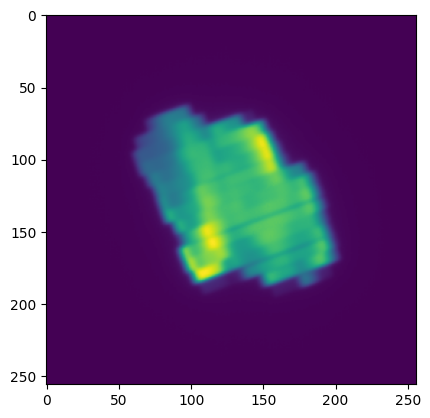

In [19]:
iterx = iter(test_dataset.repeat())
test_len =  len(test_dataset)
x, y = next(iterx)
plt.imshow(x[0,...,0])

Build the model, first create the sub-componets, the downsamping and upsamping blocks. Full model is created with call to Generator()

In [22]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
def Generator(kernel_size=4, layers=7, filters_start=64, double_layers=4, add_5cm_keys=False, activation='tanh', **kwargs):
  """
  default values creates the original generator, filters double from start
  to a max after the number of 'double layers'
  kernel_size is the kernel size
  Layers is the number of layers
  """
  channels = 3
  if add_5cm_keys:
    channels = 5
  inputs = tf.keras.layers.Input(shape=[256, 256, channels])
  filters_list = []
  for _ in range(double_layers):
    filters_list.append(filters_start)
    filters_start *= 2
  up_filters = []
  batchnorm = False
  down_stack = []
  for _ in range(layers):
    if filters_list:
      filters = filters_list.pop(0)
    up_filters.append(filters)
    layer = downsample(filters, kernel_size, batchnorm)
    down_stack.append(layer)
    batchnorm = True
  if filters_list:
    filters = filters_list.pop(0)
  layer = downsample(filters, kernel_size, batchnorm)
  down_stack.append(layer)
  up_stack = []
  for _ in range(layers):
    filters = up_filters.pop()
    layer = upsample(filters, kernel_size)
    up_stack.append(layer)
  initializer = tf.random_normal_initializer(0., 0.02)
  if activation == 'Linear':
    activation = None
  last = tf.keras.layers.Conv2DTranspose(1, kernel_size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation=activation)  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Set the Generator parameters and load weights.  The path will have to be changed to where you have saved the h5 file in your google drive.

In [26]:
generator = Generator(kernel_size=4, layers=6, filters_start=16, double_layers=4)
generator.load_weights('/content/drive/MyDrive/Colab Notebooks/logs_CB/batch2new/final_model.h5')

## Generate some images using the test set

This will set the parameters the gamma evaluation (perhaps you don't care about this)

In [27]:
gamma_options = {
    'dose_percent_threshold': 3,
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 10,
    'interp_fraction': 20,  # Should be 10 or more, see the paper referenced above
    'max_gamma': 2,
    'random_subset': None,  # Can be used to get quick pass rates
    'local_gamma': False,  # Change to false for global gamma
    'ram_available': 2**29  # 1/2 GB
}

In [28]:
xepidmin = -215.04
xepidmax = 215.04
yepidmin = -215.04
yepidmax = 215.04
grid = 1.68
xepid = np.arange(xepidmin,xepidmax,grid)
yepid = np.arange(yepidmin,yepidmax,grid)
coords = (yepid,xepid)

Grab an example from the test_dataset, will display the measured rtimage and predicted image.  The prediction uses the prediction of the scatter and the attenuation function based on the open portal dosimetry image and CBCT projection.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Calcing using global normalisation point for gamma
Global normalisation set to 0.3438434302806854
Global dose threshold set to [0.0103153] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 0.0343843437731266 (10% of normalisation)

Current distance: 5.10 mm | Number of reference points remaining: 2 | Points tested per reference point: 215 | RAM split count: 1
Complete!


Text(0.5, 1.0, 'Local Gamma (3%/3mm) | Percent Pass: 96.26 %')

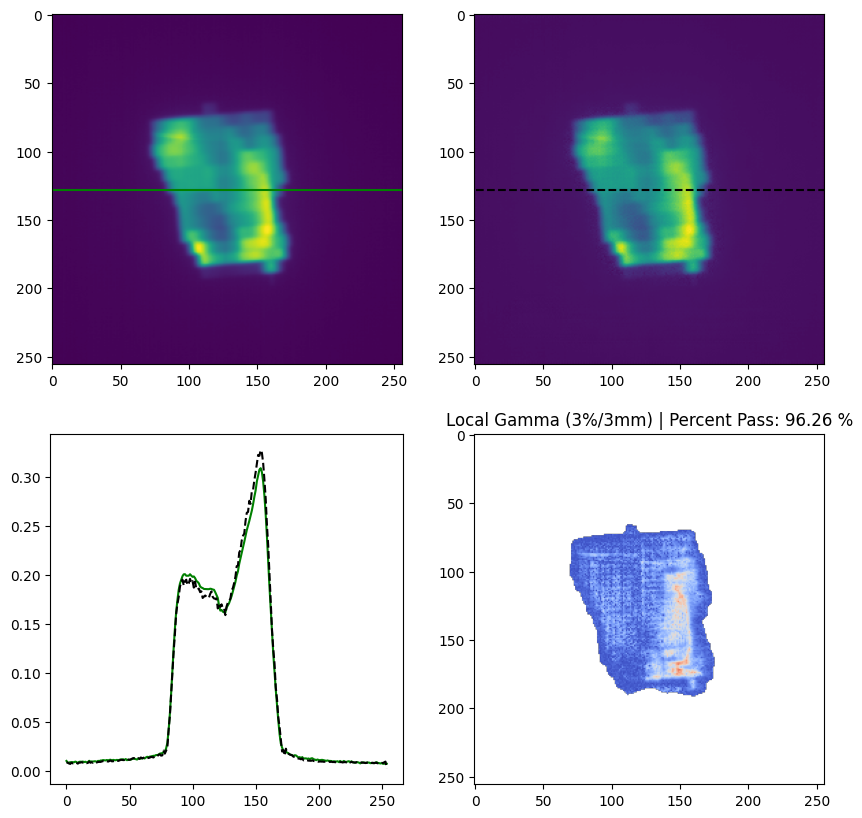

In [29]:
example = next(iter(test_dataset))
input = example[0]
# The target is the measured RTimage
tar = example[1]

# Generate the prediction image
prediction = generator.predict(input)

diff = tf.subtract(tar,prediction)
diff = tf.squeeze(diff, axis=0)
diffvec = diff[120,1:256]
tar = tf.squeeze(tar, axis=0)
tar = tf.squeeze(tar, axis=-1)
rtimage = tar

# Get the input tensor and break into open field EPID (PDOS) the projection through the CBCT and the projection through the CBCT only to isocenter.
pdos = input[0,...,0].numpy()
cbct = input[0,...,1].numpy()
half = input[0,...,2].numpy()


prediction = tf.squeeze(prediction, axis=0)
prediction = tf.squeeze(prediction, axis=-1)
prediction = prediction
crossval = 128

# Use the analytic function and scatter componet to make the complete RTimage and image prediction


rtimage = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
prediction = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
x = [1, 256]
y = [crossval, crossval]
plt.plot(x, y, color="g")
plt.imshow(rtimage)

plt.subplot(2, 2, 2)
plt.plot(x, y, "k--")
plt.imshow(prediction)

# Take the profile through the images.
predvec = prediction[128,1:256]
rtvec = rtimage[128,1:256]

#predvec = prediction[1:256,128]
#rtvec = rtimage[1:256,128]



plt.subplot(2, 2, 3)
plt.plot(rtvec,'g')
#plt.title("Meas RT IMG (Green)")
plt.plot(predvec,'k--')
#plt.ylim([0,0.6])
#print(str(example["fname"]))

gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options)
valid_gamma = gamma_test[~np.isnan(gamma_test)]

num_bins = (
    gamma_options['interp_fraction'] * gamma_options['max_gamma'])
bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

#gamma_no_noise = pymedphys.gamma(coords, rtimage, coords, prediction,**gamma_options)
plt.subplot(2, 2, 4)

plt.imshow( gamma_test, clim=(0, 2), cmap='coolwarm')

# plt.hist(valid_gamma, bins, density=True)
# plt.xlim([0, gamma_options['max_gamma']])
pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
plt.title(f"Local Gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Percent Pass: {pass_ratio*100:.2f} %")

Same Code Just forgoing the gamma calculation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


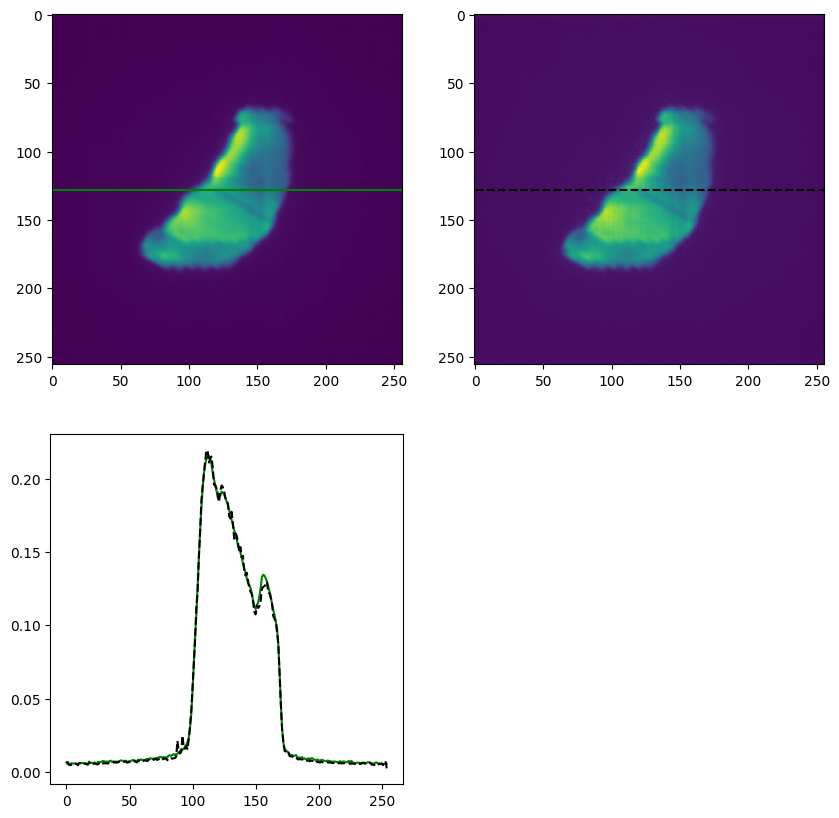

In [32]:
example = next(iter(test_dataset))
input = example[0]
# The target is the measured RTimage
tar = example[1]

# Generate the prediction image
prediction = generator.predict(input)

diff = tf.subtract(tar,prediction)
diff = tf.squeeze(diff, axis=0)
diffvec = diff[120,1:256]
tar = tf.squeeze(tar, axis=0)
tar = tf.squeeze(tar, axis=-1)
rtimage = tar

# Get the input tensor and break into open field EPID (PDOS) the projection through the CBCT and the projection through the CBCT only to isocenter.
pdos = input[0,...,0].numpy()
cbct = input[0,...,1].numpy()
half = input[0,...,2].numpy()


prediction = tf.squeeze(prediction, axis=0)
prediction = tf.squeeze(prediction, axis=-1)
prediction = prediction
crossval = 128

# Use the analytic function and scatter componet to make the complete RTimage and image prediction


rtimage = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
prediction = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
x = [1, 256]
y = [crossval, crossval]
plt.plot(x, y, color="g")
plt.imshow(rtimage)

plt.subplot(2, 2, 2)
plt.plot(x, y, "k--")
plt.imshow(prediction)

# Take the profile through the images.
predvec = prediction[128,1:256]
rtvec = rtimage[128,1:256]

#predvec = prediction[1:256,128]
#rtvec = rtimage[1:256,128]



plt.subplot(2, 2, 3)
plt.plot(rtvec,'g')
#plt.title("Meas RT IMG (Green)")
plt.plot(predvec,'k--')
#plt.ylim([0,0.6])
#print(str(example["fname"]))



In [33]:
generator.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 128, 128,  │        768 │ input_layer_14[0… │
│ (Sequential)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 64, 64,    │      8,320 │ sequential_13[0]… │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 32, 32,    │     33,024 │ sequential_14[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 16, 16,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 8, 8, 128) │    262,656 │ sequential_16[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 4, 4, 128) │    262,656 │ sequential_17[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 2, 2, 128) │    262,656 │ sequential_18[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_20       │ (None, 4, 4, 128) │    262,656 │ sequential_19[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 4, 4, 256) │          0 │ sequential_20[0]… │
│ (Concatenate)       │                   │            │ sequential_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_21       │ (None, 8, 8, 128) │    524,800 │ concatenate_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 8, 8, 256) │          0 │ sequential_21[0]… │
│ (Concatenate)       │                   │            │ sequential_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_22       │ (None, 16, 16,    │    524,800 │ concatenate_7[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 16, 16,    │          0 │ sequential_22[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_23       │ (None, 32, 32,    │    262,400 │ concatenate_8[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 32, 32,    │          0 │ sequential_23[0]… │
│ (Concatenate)       │ 128)              │            │ sequential_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_24       │ (None, 64, 64,    │     65,664 │ concatenate_9[0]

 Total params: 2,618,945 (9.99 MB)

 Trainable params: 2,616,737 (9.98 MB)

 Non-trainable params: 2,208 (8.62 KB)